**SECTION OBJECTIVES**
* Improving Bankruptcy Model using `RANDOM FOREST`
* Evaluating model generalisability using `CROSS VALIDATION`
* Hyperparamter Tuning using `GRID SEARCH`
* Building `PREDICTION FUNCTION` on saved model

**ML WORKFLOW**
* PREPARING DATA
    * Importing
    * Exploring
    * Splitting
    * Resampling: `Over Sampling`
* BUILDING MODEL
    * Baselining
    * Iterating: ensemble model, bagging (`Random Forest`), `Cross Validation`, `Grid Search`
    * Evaluating: Confusion Matrix
* COMMUNICATING RESULTS
    * Feature Importances
    * Saving model as a file
    * Building `prediction` function

In [1]:
# importing necessary libraries

import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier # Predictor in this section
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split # GridsearchCV for Hyperparameter Tuning, cross_val_score for Cross Validation
from sklearn.pipeline import make_pipeline

# 1. Preparing Data
## 1.1 Importing Data

In [2]:
def wrangle(filename):
    # Opening json file and loading it into dictionary
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Loading dictionary into a DataFrame and setting index as `company_id`
    df = pd.DataFrame().from_dict(data['data']).set_index('company_id')
    
    return df

In [3]:
# Running wrangle function
df = wrangle('poland-bankruptcy-data-2009.json')
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## 1.3 Splitting Data
### Vertical Splitting

In [4]:
target = 'bankrupt'
X = df.drop(columns = target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


### Horizontal Splitting (Randomised Train-Test Split)

In [5]:
# Performing a randomised train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## 1.4 Resampling Data
### Over-Sampling

In [6]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# 2. Building Model
## 2.1 Baselining

### Baseline Accuracy Score

In [7]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## 2.2 Iterating
### Random Forest
* Instead of building single models that predict a single outcome, it is possible to have a more trustworthy prediction by using more than one model simultaneously
* **Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction
* A collection or ensemble of decision trees is called a **RANDOM FOREST**
* RANDOM FOREST employs a technique called **BAGGING** which means fitting multiple models (trained in parallel) on random subsets of data
    * A forest of decision trees is created
    * When it is time to make a prediction, each tree will cast its vote and the class with most votes becomes the final prediction
    * These multiple decision trees in a random forest model won't be given access to all features, only a random subset of features (sq. root of total features, 8 in our case)
    * By default the number of decision trees in a scikit random forest model is 100 `n_estimators`
    * After the decision trees have been trained, they need to decide whether a company would go bankrupt or not
    * Each tree gets a vote, and the final prediction would be the category that gets the most votes
    * Training occurs in parallel, which speeds up the process

In [8]:
# Creating a classifier which uses Random Forest
clf = make_pipeline(
    SimpleImputer(),  # Not specifying the imputation
    RandomForestClassifier(random_state = 42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


### Cross-Validation (K-fold)
* This is a way to tune Hyperparameters without creating a Validation set
* Creating a separate Validation set hurts performance as it deprives us of precious data points
* `K` in K-fold Cross Validation refers to the number of folds to divide the data into. By default K is usually 5 (`cv` parameter)
* One of these folds is set aside as temporary validation set, and the remaining folds are used for training. Accuracy score is calculated
* This process is repeated taking each fold as temporary validation set
* In total there would be K accuracy scores. If the accuracy scores are close to each other, that means the model generalises well
* Generally Cross-Validation occurs when tuning hyperparameters, using a `cv` argument in hyperparameter search. It is being done separately here to get a feel for it
* `n_jobs` implies the number of parallel computations to be performed. -1 means as many as possible

In [9]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv = 5, n_jobs = -1 )
print(cv_acc_scores)

[0.99670944 0.99835472 0.99769661 0.9970385  0.99901251]


* All Accuracy Scores are around 0.99. Much better performance than a single decision tree model
* All these scores are fairly close to each other, which means this model might be able to generalise well

### Parameter Grid
* Creating a dictionary with the range of hyperparameters to be evaluated for our classifier.
    * For the SimpleImputer, trying both the "mean" and "median" strategies.
    * For the RandomForestClassifier, experimenting max_depth settings between 10 and 50, by steps of 5.
    * For the RandomForestClassifier, trying n_estimators settings between 20 and 100 by steps of 10.
* Imagine a 3-D grid of dimensions 2 x 8 x 8, that's the number of combination of hyperparameters which would be tested for optimal selection
    * simpleimputer * max_depth * n_estimators

In [15]:
# Creating a dictionary `params`
params = {
    'simpleimputer__strategy': ['mean','median'],
    'randomforestclassifier__n_estimators': range(20,100,10),
    'randomforestclassifier__max_depth': range(10,50,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(20, 100, 10),
 'randomforestclassifier__max_depth': range(10, 50, 5)}

### Grid Search
* Creating a model `GridSearchCV` that includes classifier and hyperparameter grid. Setting verbose to 1

In [16]:
model = GridSearchCV(
    clf, # Classifier
    param_grid=params, # Hyperparamter dictionary 
    cv = 5, # Cross-Validation Folds
    n_jobs = -1, # Number of parallel jobs. All power possible
    verbose = 1 # Output to describe how training process is going
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(20, 100, 10),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

### Fitting Model to over-sampled training data

In [17]:
# Training model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(20, 100, 10),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

### Grid Search CV Results
* Extracting cross-validation results from model and loading them into DataFrame named `cv_results`

In [19]:
# Checking results data type from grid search 
type(model.cv_results_)

dict

In [28]:
# Converting data from dictionary into a DataFrame
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.115372,0.078341,0.020141,0.001297,10,20,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.976308,0.977953,0.976637,0.979599,0.980579,0.978215,0.001655,123
1,1.315294,0.075128,0.020272,0.003850,10,20,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.975979,0.968411,0.976308,0.970385,0.976959,0.973608,0.003508,128
2,1.761969,0.103680,0.026708,0.003029,10,30,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979599,0.977624,0.979269,0.982231,0.983213,0.980387,0.002044,119
3,1.876279,0.101286,0.029827,0.006010,10,30,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979928,0.970714,0.978611,0.973676,0.979592,0.976504,0.003667,126
4,2.455465,0.063479,0.033545,0.006044,10,40,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.981244,0.979599,0.979928,0.984205,0.984858,0.981967,0.002175,115
5,2.459189,0.081131,0.030956,0.004113,10,40,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.971372,0.976308,0.976308,0.978604,0.976372,0.002771,127
6,3.063210,0.184771,0.040810,0.002029,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984534,0.983871,0.981901,0.002488,116
7,3.239086,0.176785,0.039138,0.002999,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,125
8,3.679787,0.105170,0.052829,0.008636,10,60,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.982560,0.978611,0.976966,0.984863,0.984529,0.981506,0.003178,117
9,3.829264,0.117190,0.053627,0.008165,10,60,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.981244,0.971372,0.979928,0.975979,0.981896,0.978084,0.003934,124


* Each row represents a different set of Hyperparameters used to train a model
* There is information on how long it took to train the model
* There is info on mean test score
* The Rank of test score is also available

### Training Time vs N Estimators
* Exploring the relationship between number of estimators and training time, keeping max_depth constant

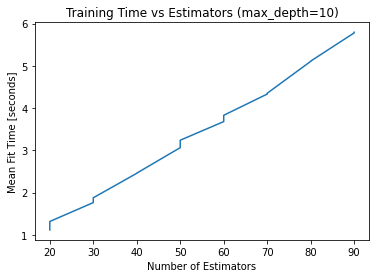

In [21]:
# Creating a mask for `cv_results` where `max_depth` is 10
mask = cv_results['param_randomforestclassifier__max_depth'] == 10

# Plotting fit time vs n_estimators
plt.plot(
    cv_results[mask]['param_randomforestclassifier__n_estimators'],
    cv_results[mask]['mean_fit_time']
)

# Labelling axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

* There is a clear direct relationship between number of estimators and Mean Fit time
* The kinks at 20, 30, 59, 60 are due to differences and time for mean and median

### Training Time vs Max Depth

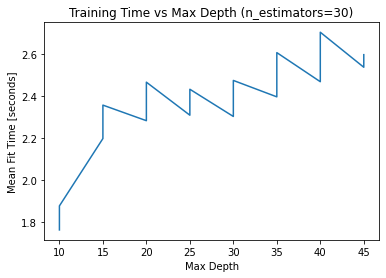

In [29]:
# Creating mask for cv_results where n_estimators is 30
mask = cv_results['param_randomforestclassifier__n_estimators'] == 30
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]['param_randomforestclassifier__max_depth'],
    cv_results[mask]['mean_fit_time']
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=30)");

* The kinks again seem to be caused due to different processing times for median and mean

In [30]:
# Checking difference in training times for median and mean when n_estimators is 30
cv_results[mask][['mean_fit_time', 'param_randomforestclassifier__max_depth','param_simpleimputer__strategy']]

,mean_fit_time,param_randomforestclassifier__max_depth,param_simpleimputer__strategy
2,1.761969,10,mean
3,1.876279,10,median
18,2.196734,15,mean
19,2.355882,15,median
34,2.281757,20,mean
35,2.465025,20,median
50,2.307934,25,mean
51,2.431402,25,median
66,2.301864,30,mean
67,2.473315,30,median


* It can be seen that for same max_depth, simple imputer strategy as median always takes more time to train than when strategy is mean
* Since median is taking longer, it makes sense to ask whether its performance is actually better

### Extracting Best Hyperparamters

In [31]:
model.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__n_estimators': 80,
 'simpleimputer__strategy': 'median'}

* it turns out that median actually did perform better
* more depth did not necessarily translate to better performance

In [32]:
model.best_score_

0.9980256013496696

## 2.3 Evaluating
### Calculating Accuracy Scores for model

In [35]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9999
Test Accuracy: 0.9594


The model was able to perform better than baseline. But barely

In [36]:
# Counting positive and negative classes in test set
y_test.value_counts()

False    1913
True       83
Name: bankrupt, dtype: int64

### Confusion Matrix
* Plotting a confusion matrix to check best model performance on test set

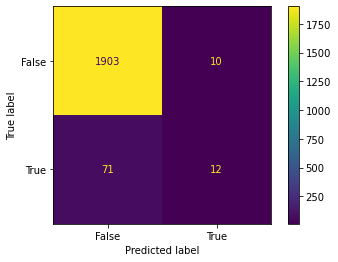

In [38]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

* This is the Confusion Matrix from previous section
* 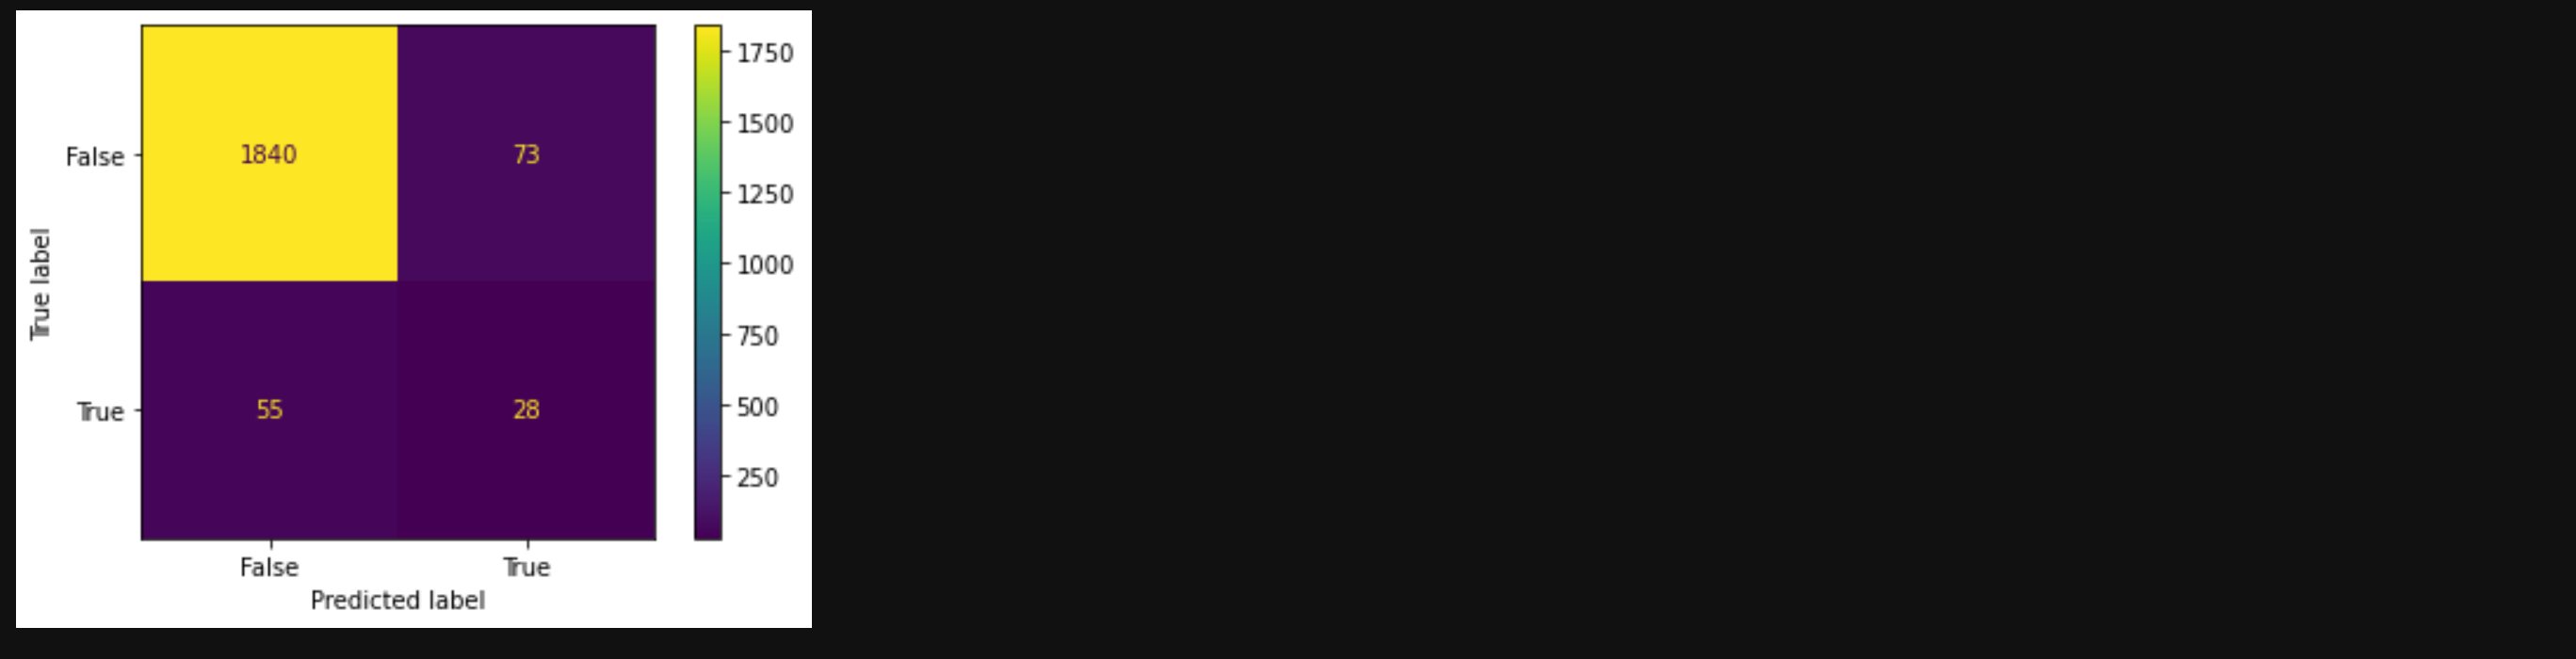
* Our model is predicting more companies would not go bankrupt, which increases its accuracy
* This strategy has its tradeoffs
    * It **DECREASES** the number of **FALSE POSITIVES** (where the model falsely predicts a healthy company to go bankrupt)
    * BUT it **INCREASES** the number of **FALSE NEGATIVES** (where the model falsely predicts a failing company to NOT go bankrupt. to survive)
    * The question which needs to be asked is whether we are satisfied with model predicting more False Negatives.
    * The answer depends on the purpose for which the model is being used.
    * If I am a conservative investor, I would be willing to tolerate a model which has a higher number of FALSE POSITIVES, erring on the side of caution

# 3. Communicating Results
## 3.1 Extracting Feature Importances

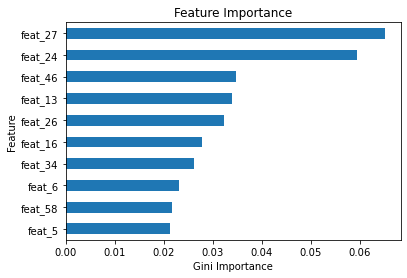

In [40]:
# Getting feature names from training data
features = X_train_over.columns

# Extracting importances from model
importances = model.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

# Creating a series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values()

# Plotting 10 most important features
feat_imp.tail(10).plot(kind = 'barh')

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

* `feat_24`	**gross profit (in 3 years) / total assets**
* `feat_27` **profit on operating activities / financial expenses**

## 3.2 Saving Model

In [41]:
with open('model-random-forest.pkl', 'wb') as f:
    pickle.dump(model, f)

## 3.3 Making Prediction Function
* Creating a function make_predictions
* It should take two arguments: the path of a JSON file that contains test data and the path of a serialized model
* The function should load and clean the data using the wrangle function, load the model, generate an array of predictions, and convert that array into a Series. 
* The Series should have the name "bankrupt" and the same index labels as the test data
* Finally, the function should return its predictions as a Series

In [42]:
def make_predictions(data_filepath, model_filepath):
    
    # Wrangling JSON file
    X_test = wrangle(data_filepath)
    
    # Loading model
    with open(model_filepath, 'rb') as f:
        model = pickle.load(f)
    
    # Generating predictions
    y_test_pred = model.predict(X_test)
    
    # Putting predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index = X_test.index, name = 'bankrupt')
    
    return y_test_pred